# (23) vH16 — fit amortized

**Motivation**: host = ```any```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

## Fit (conv)

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'conv|lin')

seq_len = 1
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_vae['n_ch'] = 64

cfg_tr['kl_beta'] = 6/4 * seq_len

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

154500

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")

poisson_vH16_t-1_z-[512]_k-64_<conv|lin>
b200-ep300-lr(0.002)_beta(1.5:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_24,14:29)

In [6]:
vae.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  3.4 Mil   |
|     ———     |    ———     |
|    layer    |  3.4 Mil   |
+-------------+------------+

In [7]:
print_num_params(vae.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  3.4 Mil   |
|     ———      |    ———     |
|     stem     |    640     |
|     enc      |  1.2 Mil   |
|    fc_enc    |  2.1 Mil   |
|    fc_dec    |  131.1 K   |
+--------------+------------+

In [8]:
tr.train()

epoch # 300, avg loss: 165.444670: 100%|████| 300/300 [1:16:15<00:00, 15.25s/it]


In [9]:
print(tr.model.layer.n_exp)

tensor([18], device='cuda:2', dtype=torch.int32)

In [12]:
name = f"<{tr.model.cfg.enc_type}|{tr.model.cfg.dec_type}>_({tr.model.cfg.seq_len},{tr.cfg.kl_beta:0.1f})"
print(name)

<conv|lin>_(1,1.5)

### Eval (conv)

100%|██████████████████████████████| 130/130 [00:01<00:00, 128.37it/s]


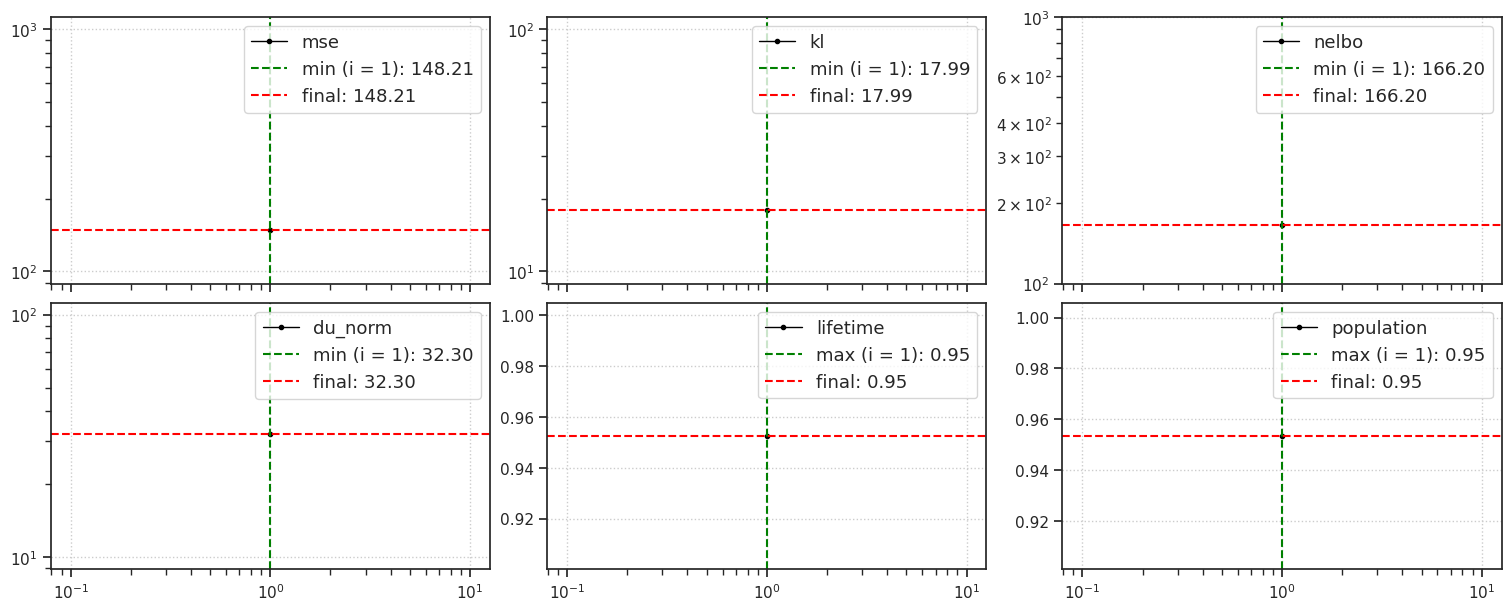

In [13]:
kws = dict(
    seq_total=1,
    seq_batch_sz=100,
    n_data_batches=None,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

In [14]:
print(name)

<conv|lin>_(1,1.5)

100%|██████████████████████████████| 130/130 [00:00<00:00, 184.59it/s]


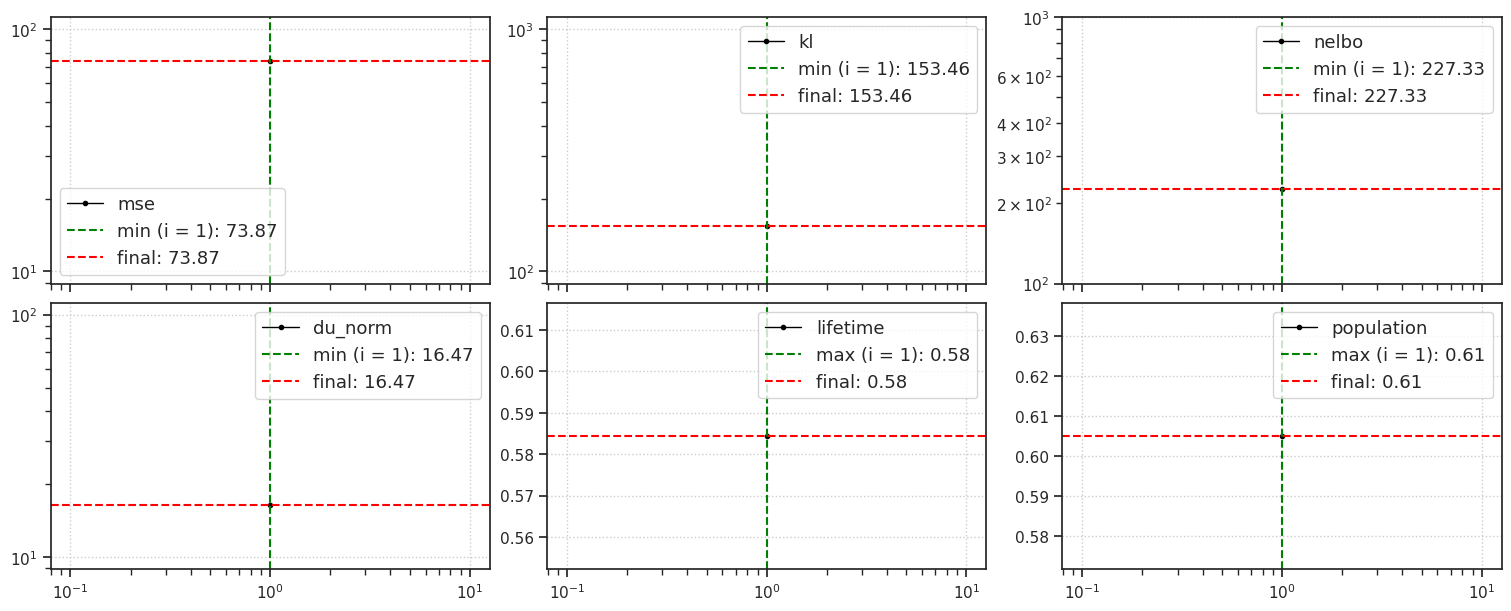

In [10]:
## n_ch = 64, beta = 0.25

100%|██████████████████████████████| 130/130 [00:00<00:00, 131.69it/s]


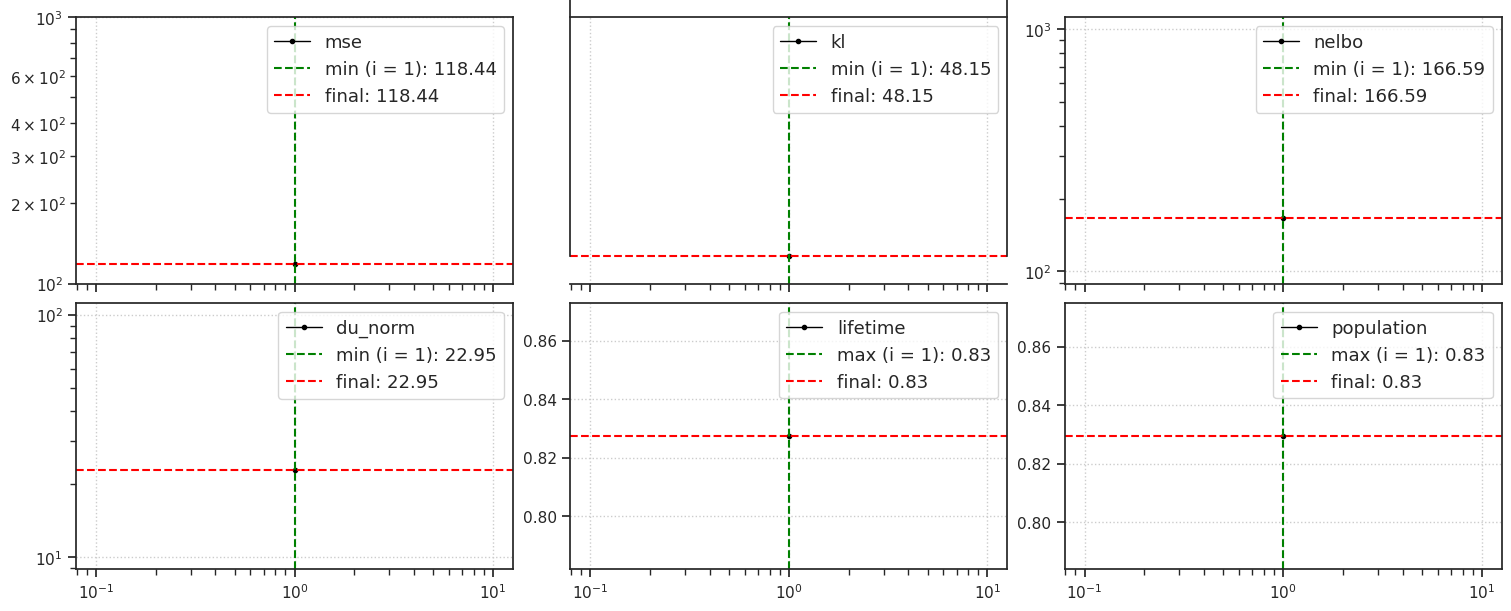

In [10]:
## n_ch = 64, beta = 0.75

100%|██████████████████████████████| 130/130 [00:00<00:00, 175.79it/s]


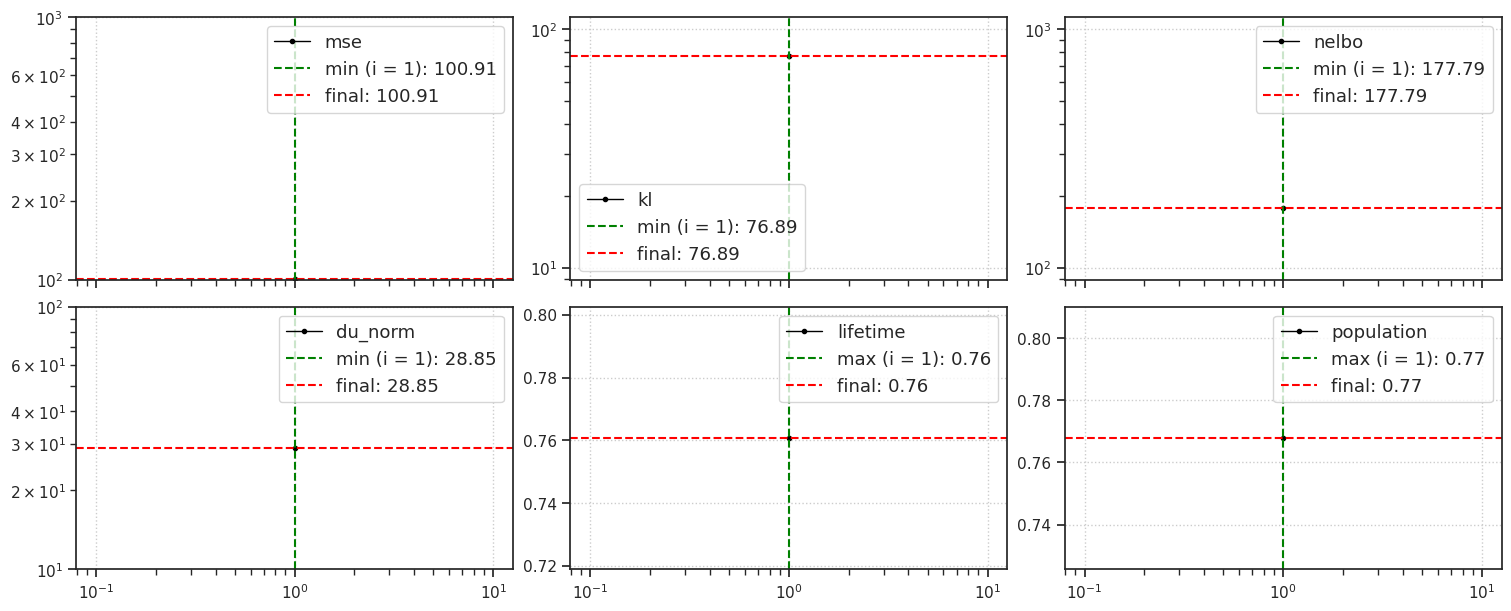

In [11]:
## n_ch = 64, beta = 0.5

100%|██████████████████████████████| 130/130 [00:00<00:00, 238.06it/s]


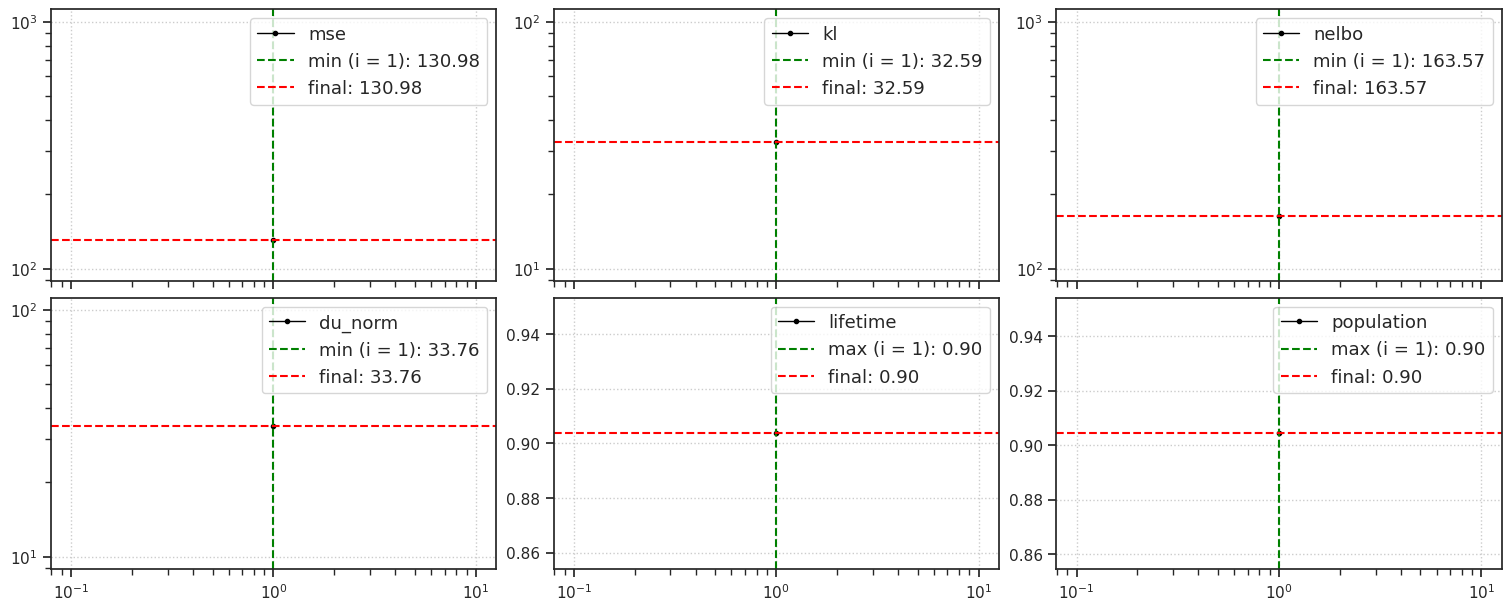

In [10]:
## n_ch = 64, beta = 1

100%|██████████████████████████████| 130/130 [00:00<00:00, 157.96it/s]


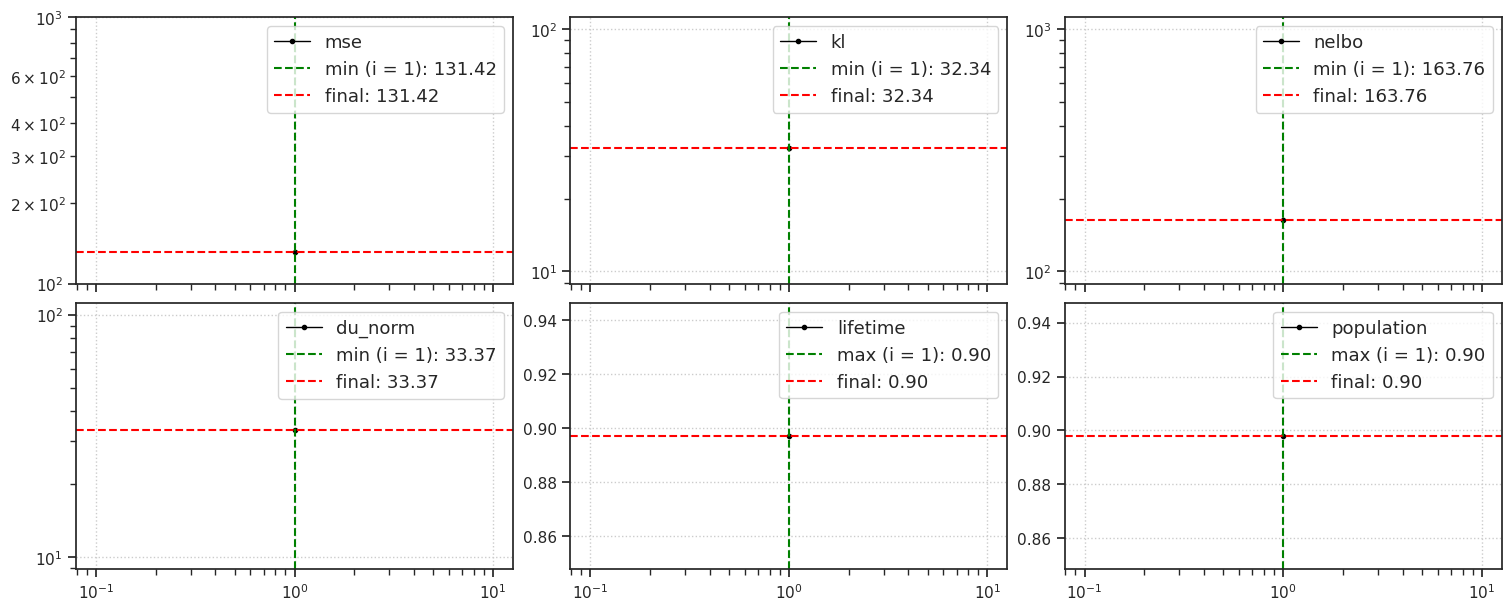

In [12]:
## n_ch = 32

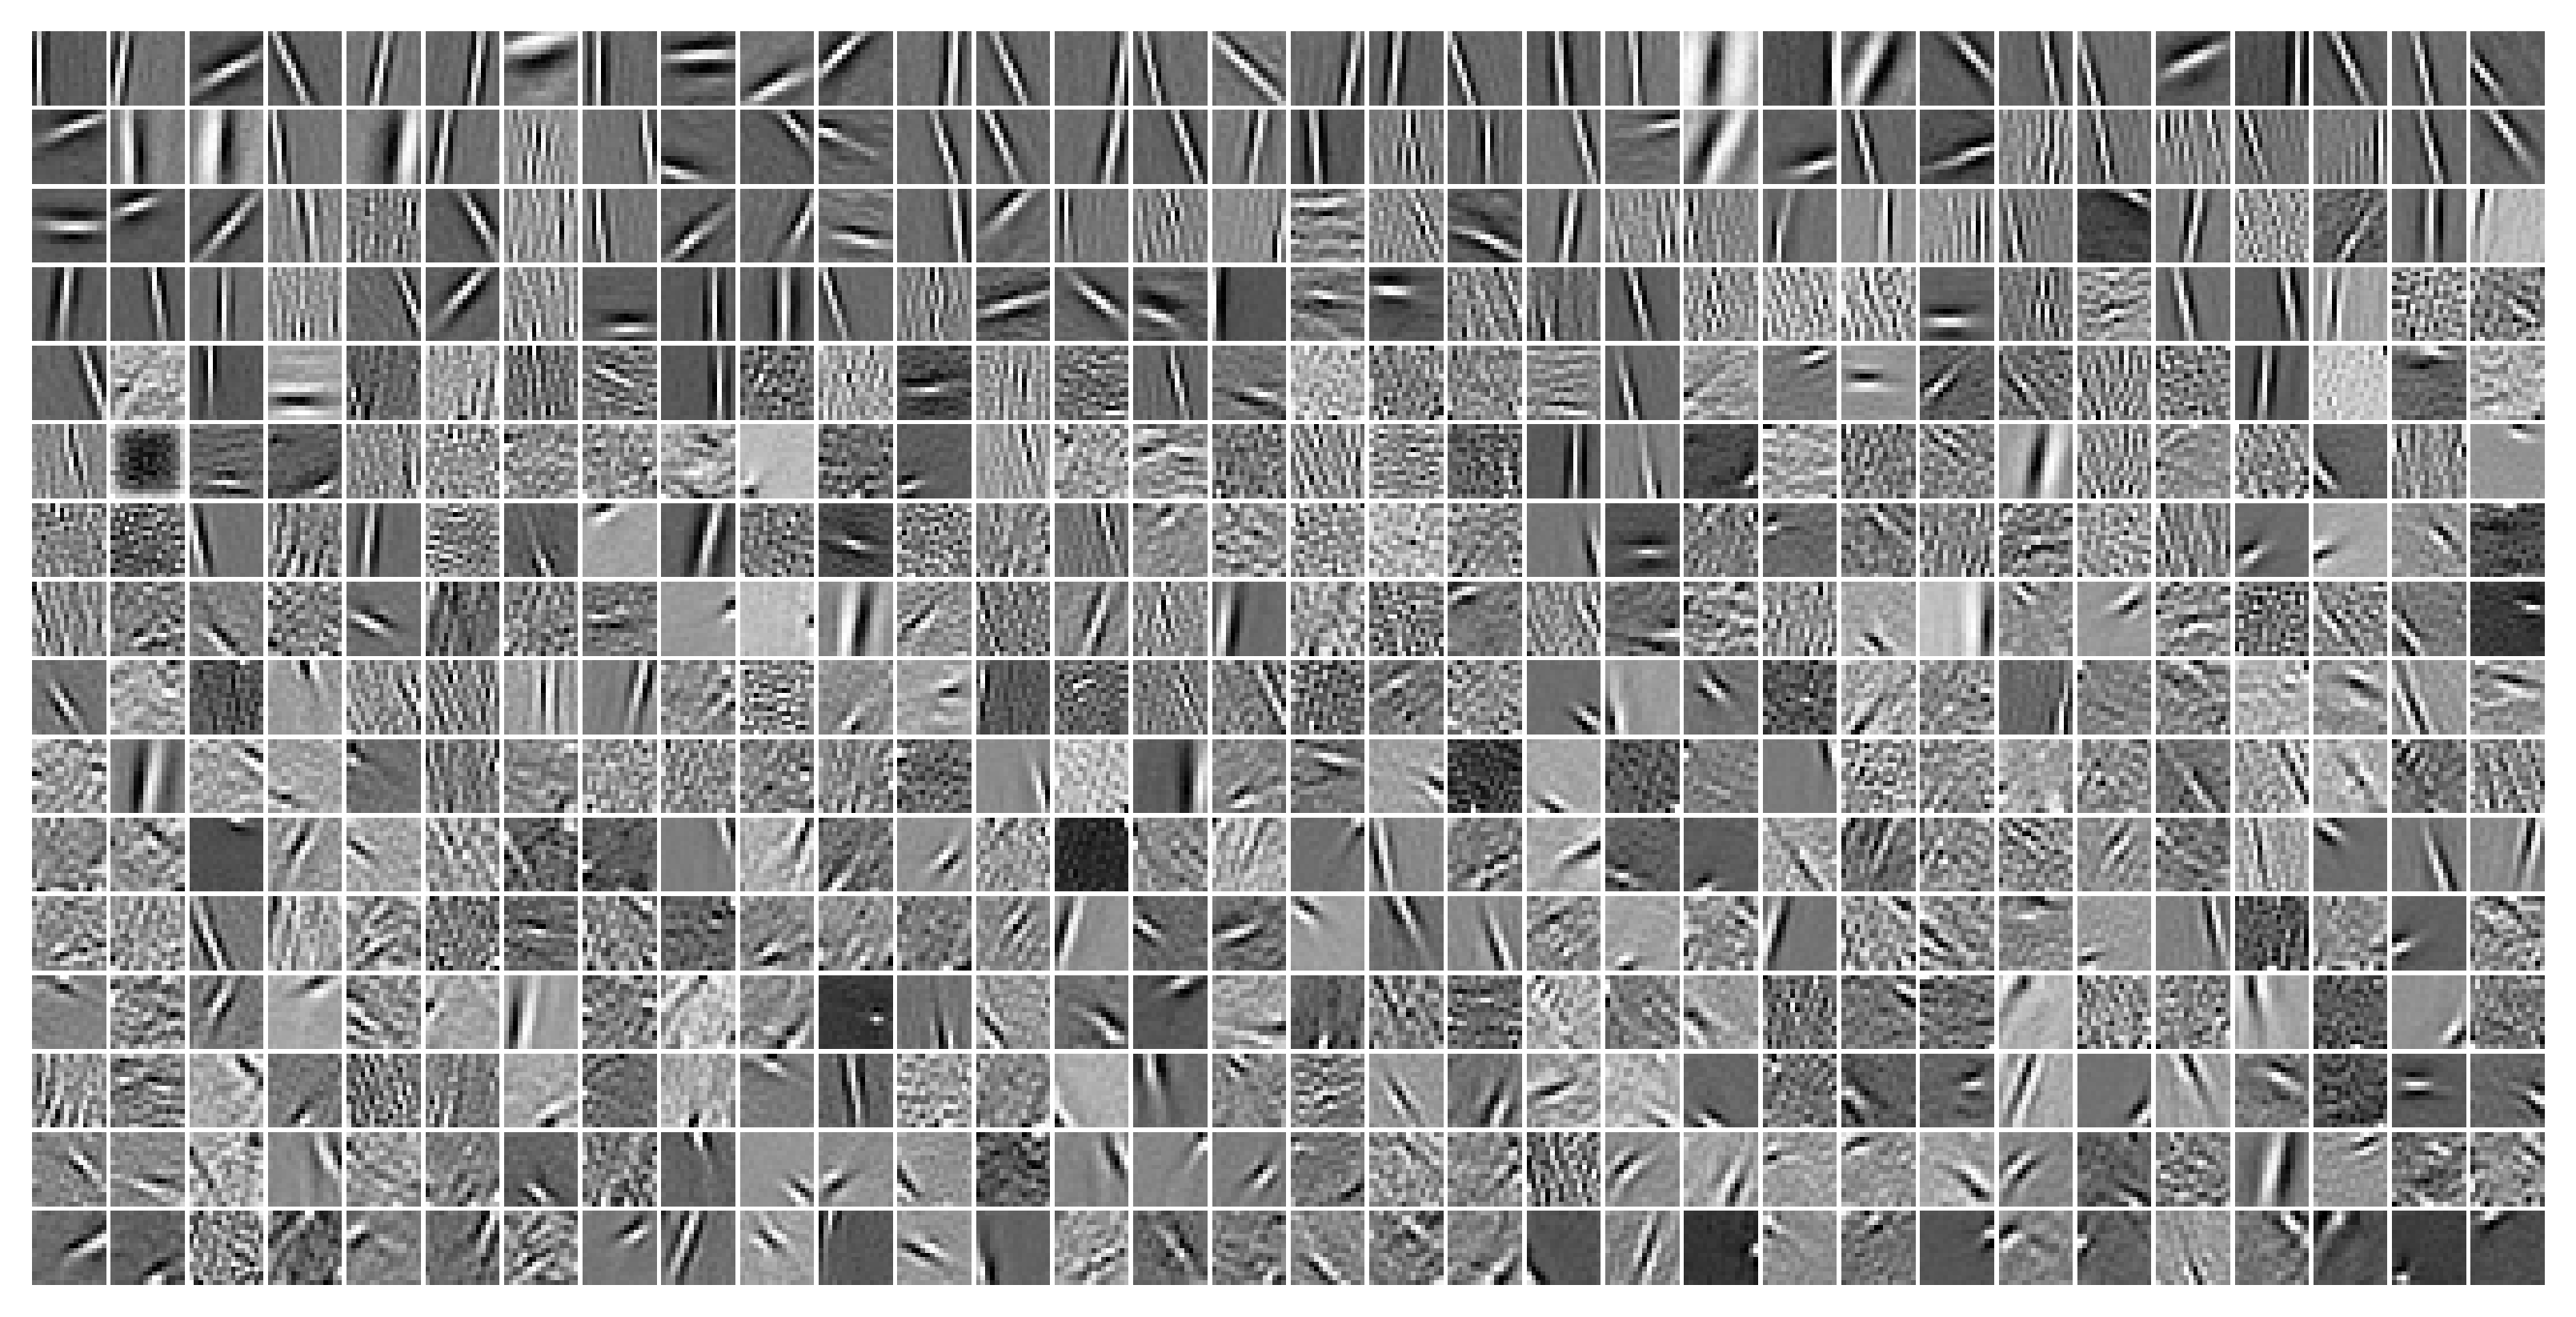

In [12]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

## Fit (lin)

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

seq_len = 1
cfg_vae['seq_len'] = seq_len
cfg_tr['kl_beta'] = 1 * seq_len
cfg_tr['kl_anneal_portion'] = 0.5
cfg_tr['batch_size'] = 1000
cfg_tr['epochs'] = 3000

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

309000

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")

poisson_vH16_t-1_z-[512]_<lin|lin>
b1000-ep3000-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(200)_(2024_09_24,21:51)

In [6]:
vae.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  263.2 K   |
|     ———     |    ———     |
|    layer    |  263.2 K   |
+-------------+------------+

In [7]:
print_num_params(vae.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  263.2 K   |
|     ———      |    ———     |
|    fc_enc    |  131.1 K   |
|    fc_dec    |  131.1 K   |
+--------------+------------+

In [8]:
tr.train()

epoch # 3000, avg loss: 164.567753: 100%|█| 3000/3000 [2:20:08<00:00,  2.80s/it]


In [9]:
print(tr.model.layer.n_exp)

tensor([28], device='cuda:0', dtype=torch.int32)

In [11]:
name = f"<{tr.model.cfg.enc_type}|{tr.model.cfg.dec_type}>_({tr.model.cfg.seq_len},{tr.cfg.kl_beta:0.1f})"
print(name)

<lin|lin>_(1,1.0)

### Eval (lin)

100%|█████████████████████████████████| 26/26 [00:00<00:00, 48.29it/s]


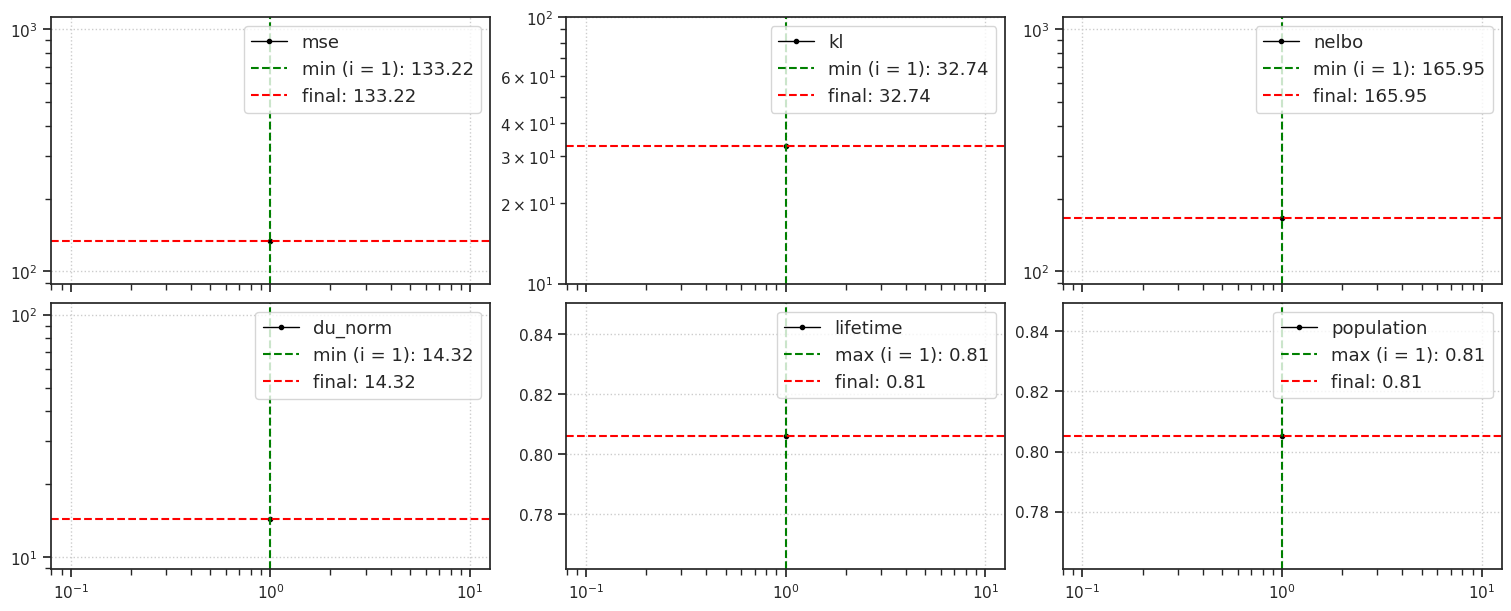

In [12]:
kws = dict(
    seq_total=1,
    seq_batch_sz=100,
    n_data_batches=None,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

In [13]:
print(name)

<lin|lin>_(1,1.0)

100%|██████████████████████████████| 130/130 [00:00<00:00, 131.69it/s]


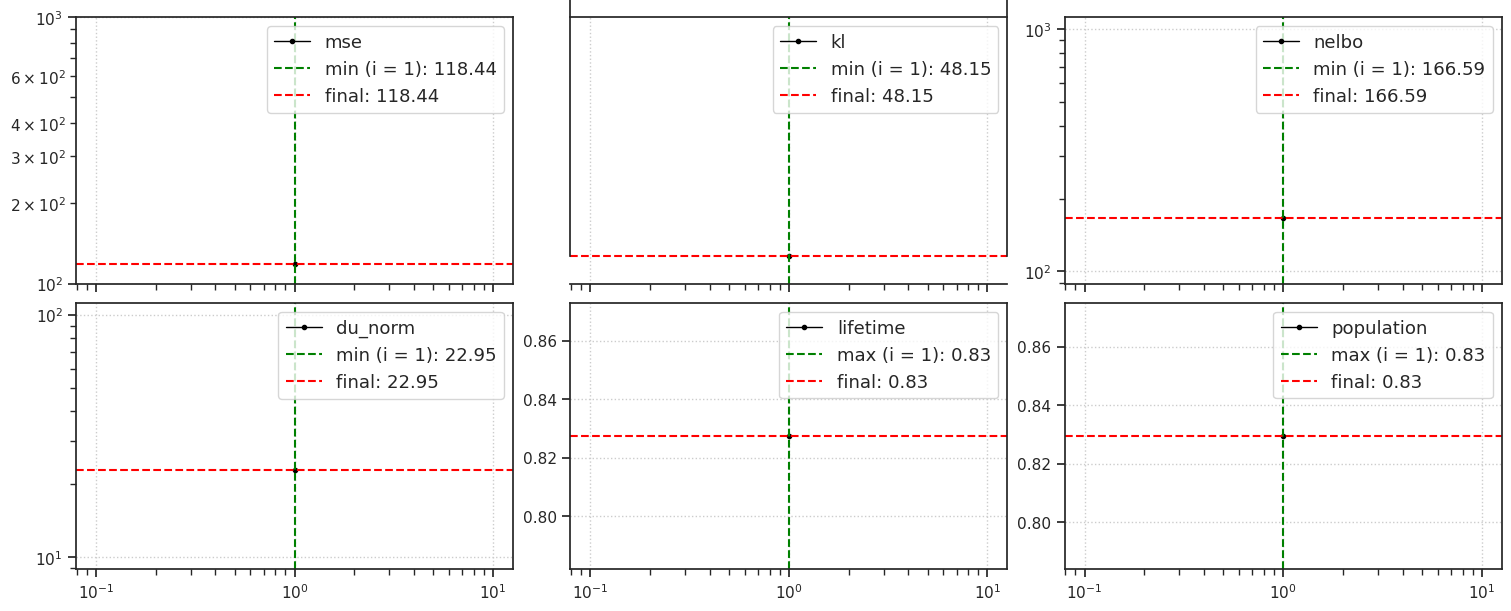

In [10]:
## n_ch = 64, beta = 0.75

100%|██████████████████████████████| 130/130 [00:00<00:00, 175.79it/s]


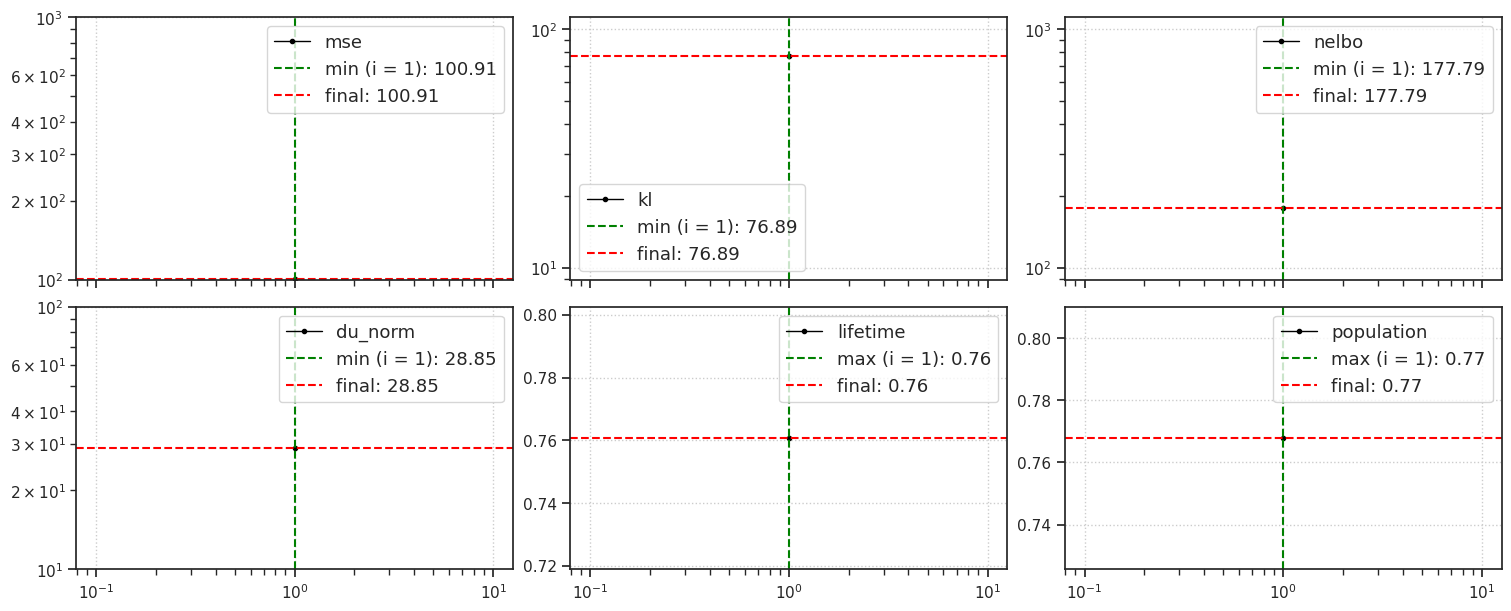

In [11]:
## n_ch = 64, beta = 0.5

100%|██████████████████████████████| 130/130 [00:00<00:00, 238.06it/s]


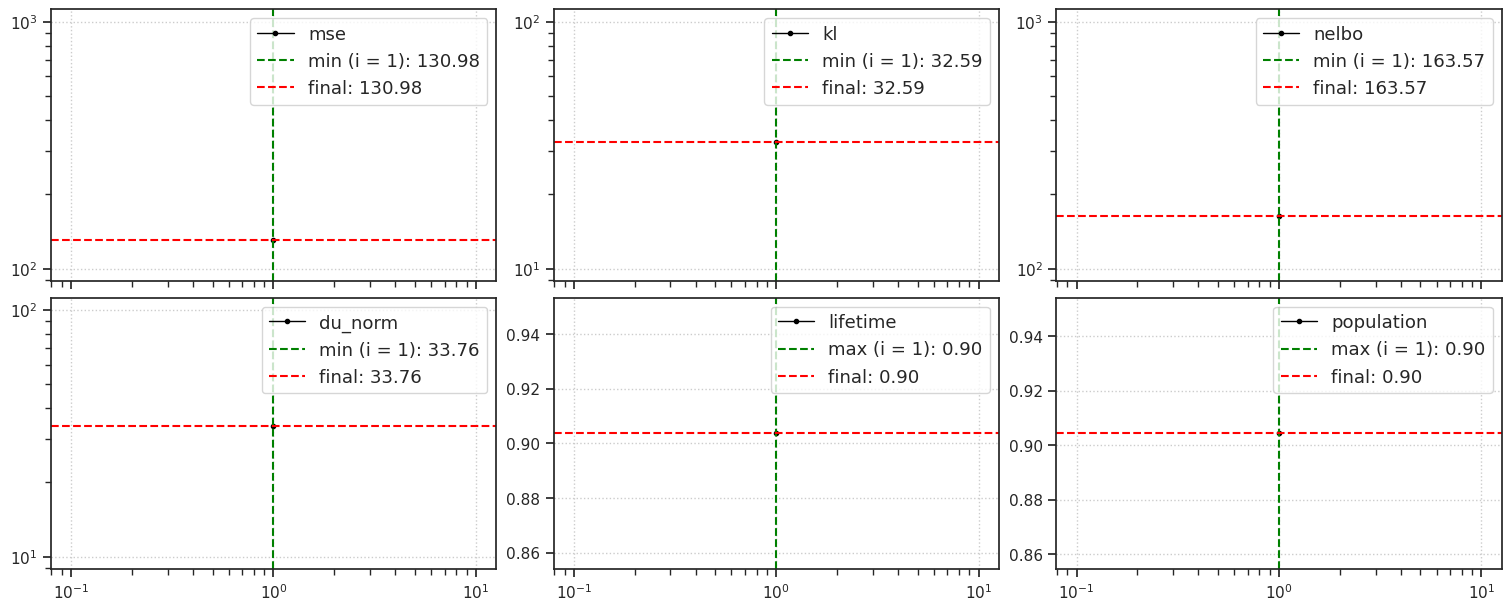

In [10]:
## n_ch = 64, beta = 1

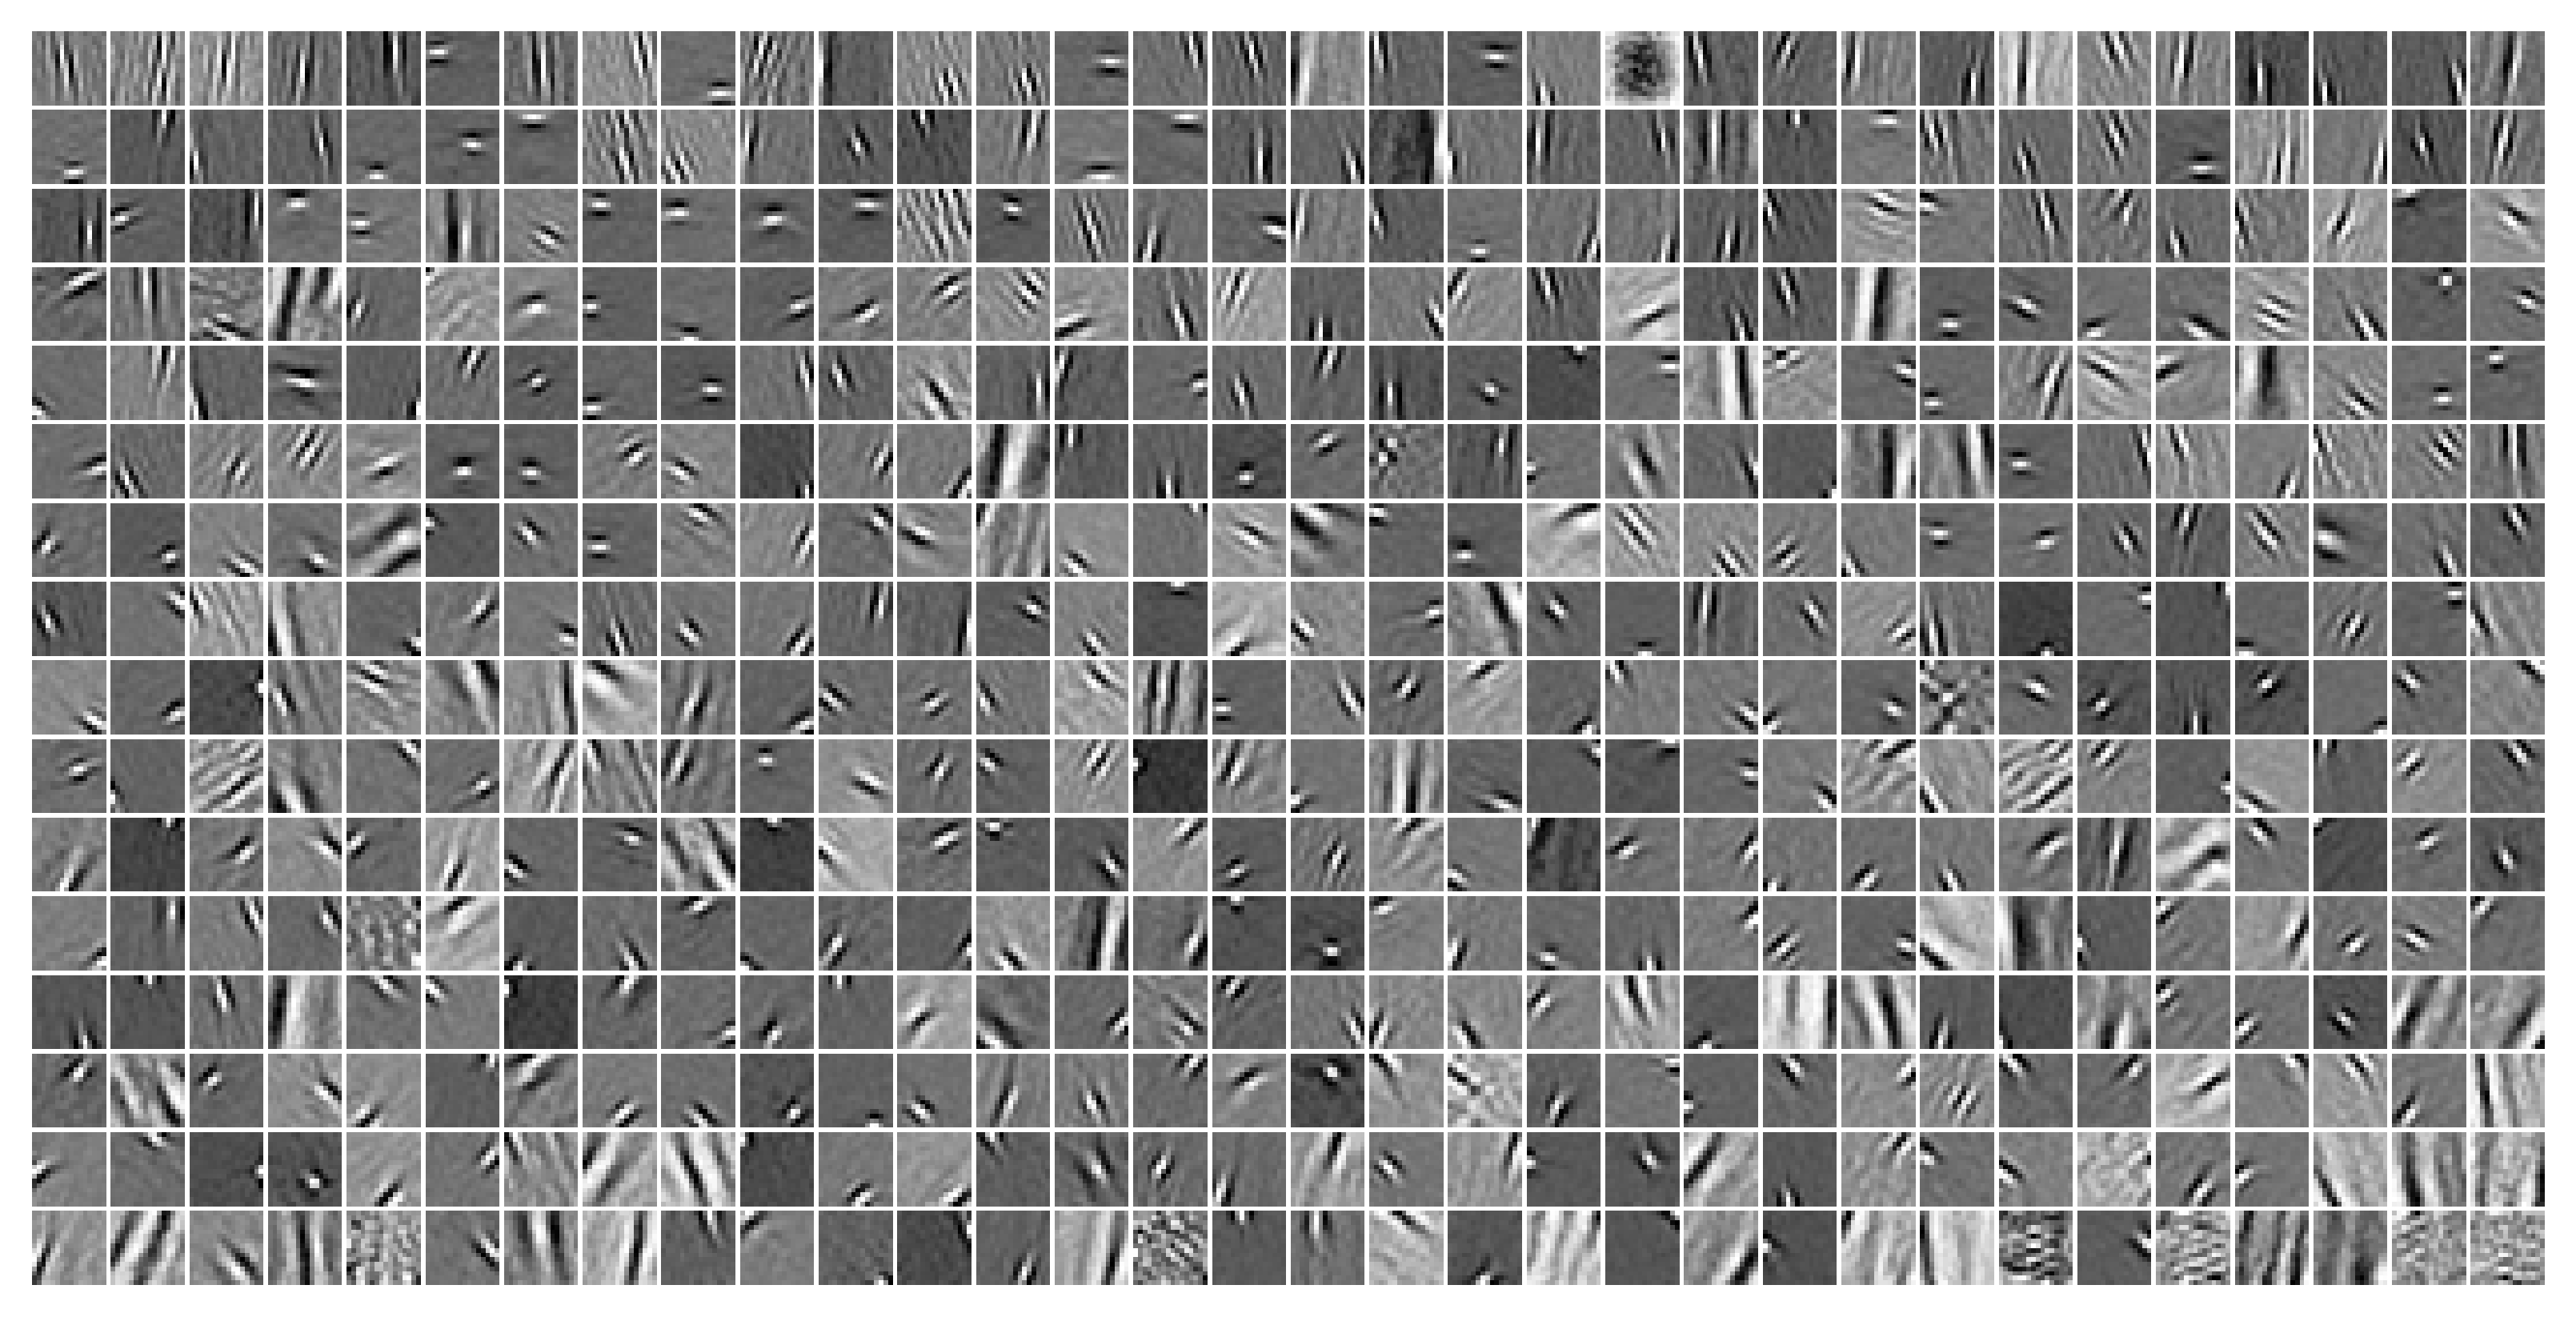

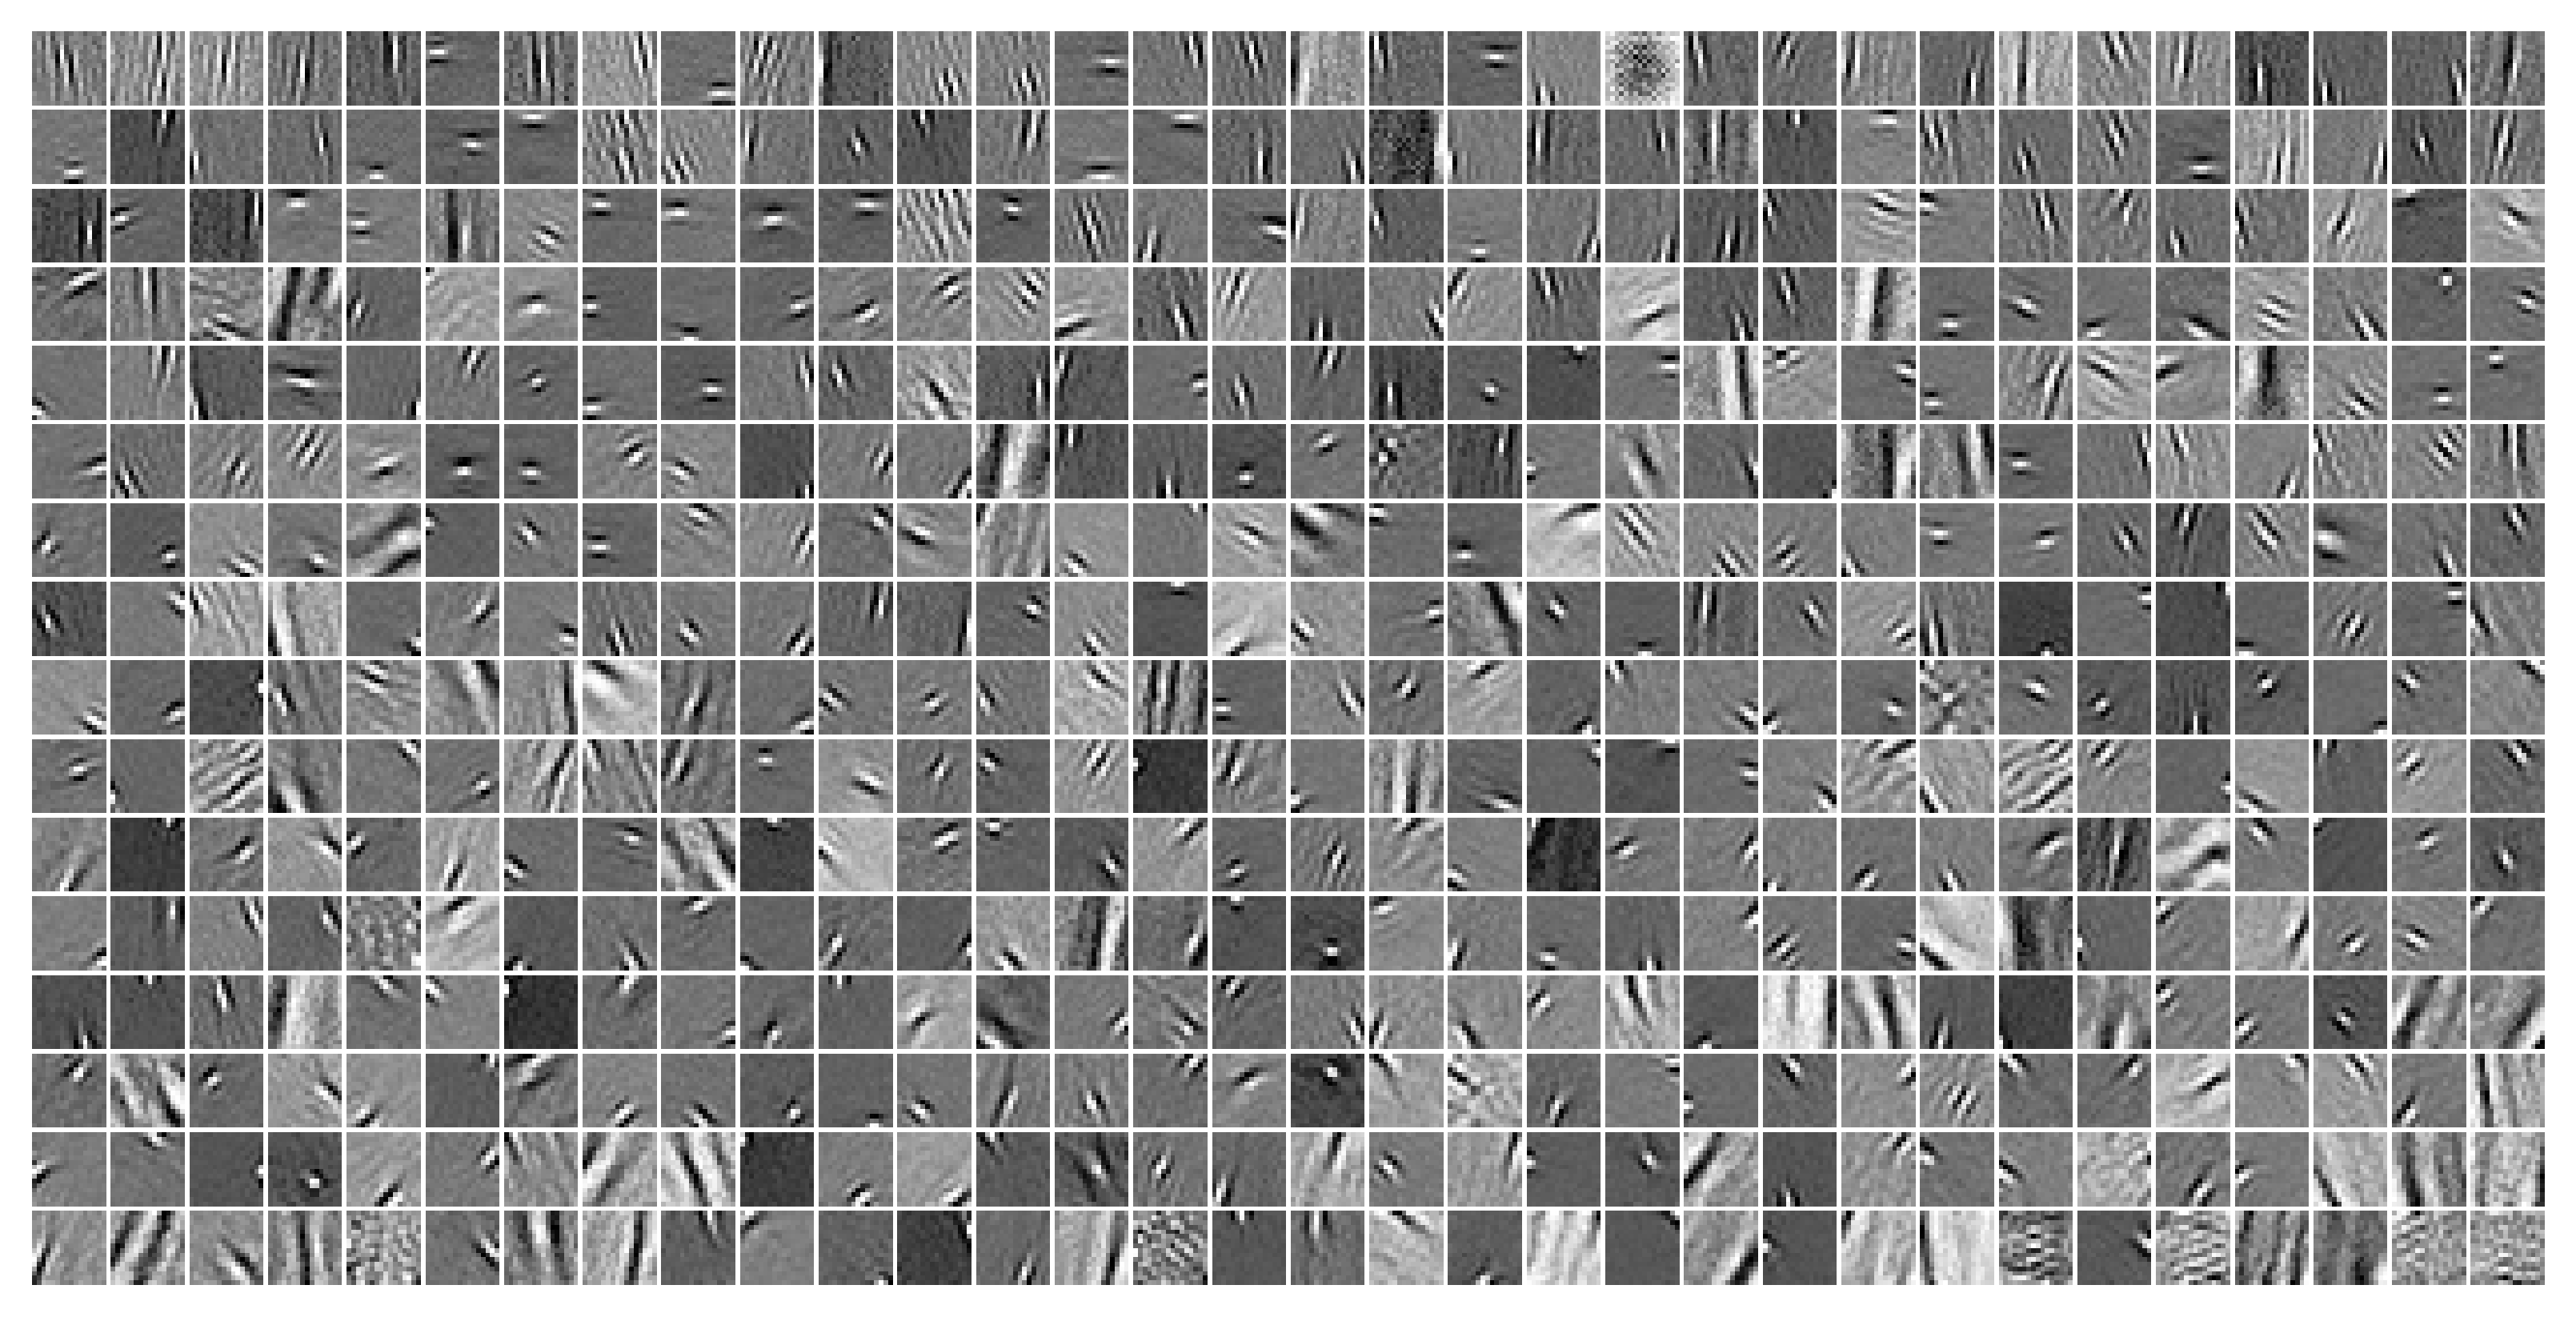

In [14]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show('dec', order=np.argsort(log_rate), dpi=400);
tr.model.show('enc', order=np.argsort(log_rate), dpi=400);

In [26]:
w_dec = tr.model.layer.get_weight('dec')
w_enc = tr.model.layer.get_weight('enc')
w_dec.shape, w_enc.shape

(torch.Size([512, 256]), torch.Size([512, 256]))

In [41]:
def pairwise_cosine_similarity(x, y):
    x_norm = F.normalize(x, p=2, dim=1)
    y_norm = F.normalize(y, p=2, dim=1)
    cosine_sim = torch.sum(x_norm * y_norm, dim=1)
    
    return cosine_sim

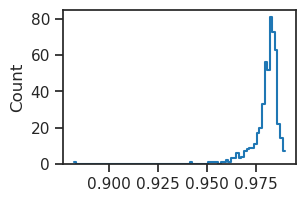

In [42]:
cos_sim = pairwise_cosine_similarity(w_dec, w_enc)
cos_sim = tonp(cos_sim)
histplot(cos_sim);

In [34]:
cos_sim.mean(), cos_sim.std()

(0.98016024, 0.007529353)

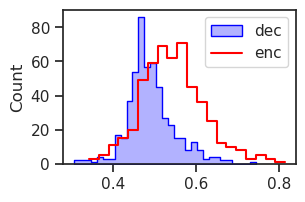

In [50]:
norms_dec = torch.linalg.norm(w_dec, dim=1)
norms_enc = torch.linalg.norm(w_enc, dim=1)

histplot(tonp(norms_dec), color='b', label='dec', fill=True, alpha=0.3)
histplot(tonp(norms_enc), color='r', label='enc')
plt.legend()
plt.show()